In [1]:
import nengo
import nengo_spa as spa
import numpy as np

In [2]:
from matplotlib import pyplot as plt

In [3]:
#create semantic pointers
words = [ 'CAT', 'BLUE', 'RED']
colors = ['RED', 'BLUE']
fingers = ['INDEX', 'MIDDLE']

D = 16 #we reduced it from 32 cause of capacity of our computers
vocab = spa.Vocabulary(D)
vocab.populate(';'.join(words))
vocab.populate('COLOR; WORD')
vocab.populate(';'.join(fingers))

stimuli = []
for i in range(10):
    w = np.random.choice(colors)
    c = np.random.choice(colors)
    stimuli.append((w,c))

# No recurrent connections

In [4]:
model = spa.Network()
with model:
   
    t_stim = 0.5
    t_isi = 0.5
    def word_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][0]
    def color_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][1]
    stim_w = spa.Transcode(word_func, output_vocab=vocab)
    #create node for pre processing color to mimic delay 
    pre_stim_c = spa.Transcode(color_func, output_vocab=vocab)    
    stim_c = spa.State(vocab)    
    #reduced amount of neurons to increase volatility of attention
    attention = spa.State(vocab, neurons_per_dimension=10)
    spa.sym.WORD * 0.45 + spa.sym.COLOR * 0.55 >> attention
   
    wm = spa.State(vocab)
   
    nengo.Connection(pre_stim_c.output, stim_c.input, synapse=0.3)
    #added gain for action selection to be triggered
    (spa.sym.COLOR*stim_c+spa.sym.WORD*stim_w)*~attention*2 >> wm
   
    finger = spa.State(vocab)
   
    with spa.ActionSelection():
        spa.ifmax( spa.dot(wm, spa.sym.BLUE),
            spa.sym.INDEX >> finger)
        spa.ifmax(spa.dot(wm, spa.sym.RED),
            spa.sym.MIDDLE >> finger)
        spa.ifmax(0.5,
            spa.semantic_pointer.Zero(D) >> finger)

In [5]:
with model:
    p_input_word = nengo.Probe(stim_w.output)
    p_input_color = nengo.Probe(pre_stim_c.output)
    p_wm = nengo.Probe(wm.output)
    p_finger = nengo.Probe(finger.output)

In [6]:
with nengo.Simulator(model) as sim:
    sim.run(5)

Build finished in 0:00:06.                                                                                              
Simulation finished in 0:00:33.                                                                                         


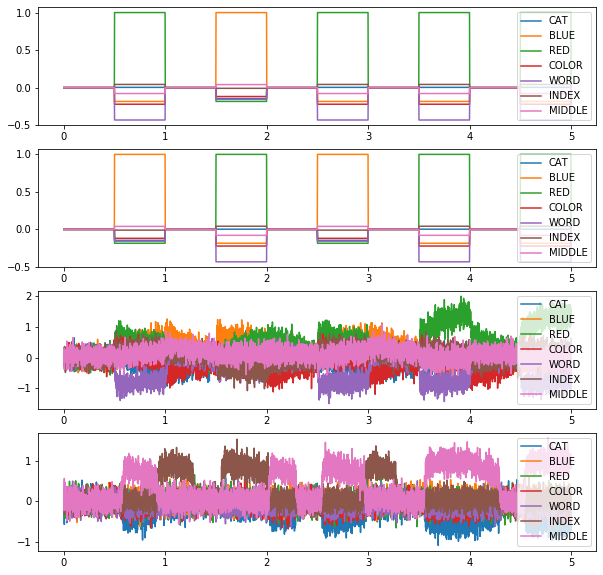

In [7]:
figuge, axs = plt.subplots(ncols=1, nrows=4, figsize=(10, 10))

axs[0].plot(sim.trange(), spa.similarity(sim.data[p_input_word], vocab))
axs[0].legend(vocab.keys(), loc='right')

axs[1].plot(sim.trange(), spa.similarity(sim.data[p_input_color], vocab))
axs[1].legend(vocab.keys(), loc='right')

axs[2].plot(sim.trange(), spa.similarity(sim.data[p_wm], vocab))
axs[2].legend(vocab.keys(), loc='right')

axs[3].plot(sim.trange(), spa.similarity(sim.data[p_finger], vocab))
axs[3].legend(vocab.keys(), loc='right')


The delay in processing 'color' vs 'word' was successful. However the model without recurrent wm always responds incorrectly (to 'word'), as it responds to the first input to wm. Thus we decided to add recurrent feedback to the wm nodes, to achive accumulation of evidence.

# Yes recurrent connections

In [4]:
model_rec = spa.Network()
with model_rec:
   #we changed durations, to avoid intertrial effects (wm overlap)
    t_stim = 0.3
    t_isi = 0.7
    def word_func(t):
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][0]
    def color_func(t):
        #instead of achieving delay via additional node, for better control we present 'color' later than 'word'
        t -= 0.1
        index = int (t / (t_stim + t_isi))
        t = t % (t_stim + t_isi)
        if t < t_isi:
            return '0'
        else:
            return stimuli[index%len(stimuli)][1]
    
    stim_w = spa.Transcode(word_func, output_vocab=vocab)
    stim_c = spa.Transcode(color_func, output_vocab=vocab)    
    
    rec_weight_input = 1
    rec_weight_feedback = 0.5
    
    wm_w = spa.State(vocab, feedback=rec_weight_feedback)
    wm_c = spa.State(vocab, feedback=rec_weight_feedback)
    
    stim_w * rec_weight_input >> wm_w
    stim_c * rec_weight_input >> wm_c    
    
    attention = spa.State(vocab, neurons_per_dimension=10)
    #we reduced attentional difference to give higher chance to'word'
    spa.sym.WORD * 0.48 + spa.sym.COLOR * 0.52 >> attention
   
    wm = spa.State(vocab, feedback=rec_weight_feedback)
    
    (spa.sym.COLOR * wm_c + spa.sym.WORD * wm_w) * ~attention * rec_weight_input * 2 >> wm
   
    finger = spa.State(vocab)
   
    with spa.ActionSelection():
        spa.ifmax( spa.dot(wm, spa.sym.BLUE),
            spa.sym.INDEX >> finger)
        spa.ifmax(spa.dot(wm, spa.sym.RED),
            spa.sym.MIDDLE >> finger)
        spa.ifmax(0.5,
            spa.semantic_pointer.Zero(D) >> finger)

In [5]:
with model_rec:
    p_input_word = nengo.Probe(stim_w.output)
    p_input_color = nengo.Probe(stim_c.output)
    p_wm_word = nengo.Probe(wm_w.output)
    p_wm_color = nengo.Probe(wm_c.output)
    p_wm = nengo.Probe(wm.output)
    p_finger = nengo.Probe(finger.output)

In [11]:
stimuli = []
for i in range(10):
    w = np.random.choice(colors)
    c = np.random.choice(colors)
    stimuli.append((w,c))

In [12]:
with nengo.Simulator(model_rec) as sim_rec:
    sim_rec.run(10)

Build finished in 0:00:10.                                                      
Simulation finished in 0:03:05.                                                 


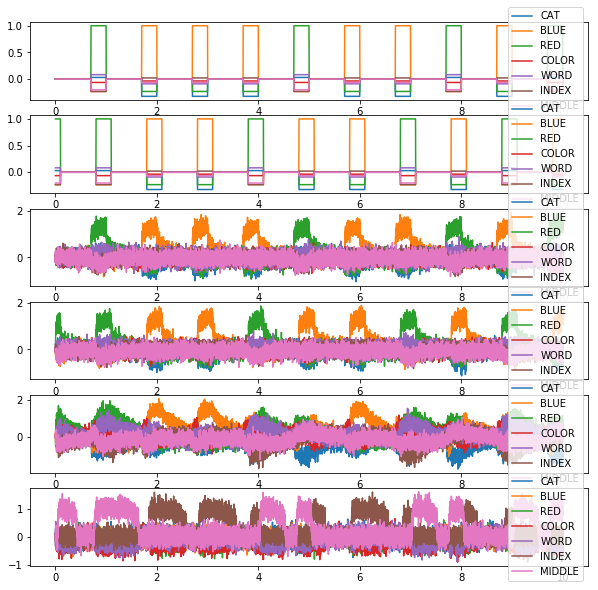

In [13]:
figuge, axs = plt.subplots(ncols=1, nrows=6, figsize=(10, 10))

axs[0].plot(sim_rec.trange(), spa.similarity(sim_rec.data[p_input_word], vocab))
axs[0].legend(vocab.keys(), loc='right')

axs[1].plot(sim_rec.trange(), spa.similarity(sim_rec.data[p_input_color], vocab))
axs[1].legend(vocab.keys(), loc='right')

axs[2].plot(sim_rec.trange(), spa.similarity(sim_rec.data[p_wm_word], vocab))
axs[2].legend(vocab.keys(), loc='right')

axs[3].plot(sim_rec.trange(), spa.similarity(sim_rec.data[p_wm_color], vocab))
axs[3].legend(vocab.keys(), loc='right')

axs[4].plot(sim_rec.trange(), spa.similarity(sim_rec.data[p_wm], vocab))
axs[4].legend(vocab.keys(), loc='right')

axs[5].plot(sim_rec.trange(), spa.similarity(sim_rec.data[p_finger], vocab))
axs[5].legend(vocab.keys(), loc='right')


This is the closest result that shows mistakes (at least we can interpret it that way): 4,5,7 & 8 timepoints where both fingers are selected (wrong finger is the first one)